In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt


import tensorflow_datasets as tfds

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import Adam




In [3]:
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True,
                                  shuffle_files = True,
                                  split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteWK78N1/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [4]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [5]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )




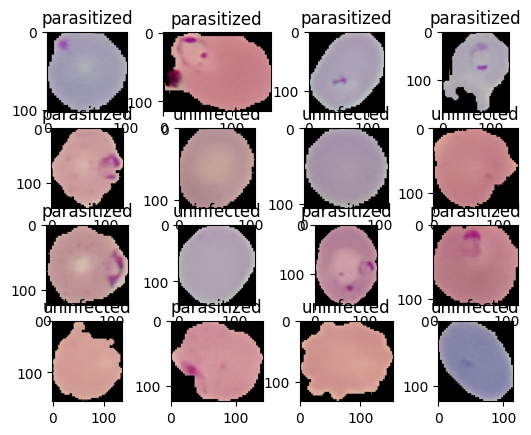

In [6]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)

  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  # plt.axis('off')



In [7]:
I_size = 244

def resizing_rescaling(image , label):
  return tf.image.resize(image , (I_size , I_size))/255 , label

In [8]:
train_dataset = train_dataset.map(resizing_rescaling)
val_dataset = val_dataset.map(resizing_rescaling)
test_dataset = test_dataset.map(resizing_rescaling)

In [9]:
for image, label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(244, 244, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [10]:
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Sequential model


In [11]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(I_size, I_size, 3)),

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 242, 242, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 242, 242, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 121, 121, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 119, 119, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 119, 119, 16)      64        
 chNormalization)                                                
                                                        

In [39]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(I_size, I_size, 3)),

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),

    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 242, 242, 6)       168       
                                                                 
 batch_normalization_31 (Ba  (None, 242, 242, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 121, 121, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_18 (Conv2D)          (None, 119, 119, 16)      880       
                                                                 
 batch_normalization_32 (Ba  (None, 119, 119, 16)      64        
 tchNormalization)                                               
                                                      

# functional api feature extractor and all

In [32]:
func_input = Input(shape=(I_size, I_size, 3) , name = 'Input_image')

x= Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu')(func_input)
x= BatchNormalization()(x)
x= MaxPool2D(pool_size=2, strides=2)(x)

x= Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu')(x)
x= BatchNormalization()(x)
output = MaxPool2D(pool_size=2, strides=2)(x)


feature_extractor = Model(func_input ,output, name = 'feature_extractor' )

feature_extractor.summary()

Model: "feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_image (InputLayer)    [(None, 244, 244, 3)]     0         
                                                                 
 conv2d_13 (Conv2D)          (None, 242, 242, 6)       168       
                                                                 
 batch_normalization_23 (Ba  (None, 242, 242, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 121, 121, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 119, 119, 16)      880       
                                                                 
 batch_normalization_24 (Ba  (None, 119, 119, 16)

In [37]:
feature_extractor_seq = tf.keras.Sequential([
    InputLayer(input_shape=(I_size, I_size, 3)),

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),
])

feature_extractor_seq.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 242, 242, 6)       168       
                                                                 
 batch_normalization_27 (Ba  (None, 242, 242, 6)       24        
 tchNormalization)                                               
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 121, 121, 6)       0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 119, 119, 16)      880       
                                                                 
 batch_normalization_28 (Ba  (None, 119, 119, 16)      64        
 tchNormalization)                                               
                                                      

In [38]:
func_input = Input(shape=(I_size, I_size, 3) , name = 'Input_image')
x= feature_extractor_seq(func_input)

x= Flatten()(x)

x= Dense(100, activation='relu')(x)
x= BatchNormalization()(x)
x= Dense(10, activation='relu')(x)
x= BatchNormalization()(x)
func_output =  Dense(1, activation='sigmoid')(x)

lenet_model = Model(func_input ,func_output, name = 'Lenet_model' )

lenet_model.summary()

Model: "Lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_image (InputLayer)    [(None, 244, 244, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 59, 59, 16)        1136      
                                                                 
 flatten_6 (Flatten)         (None, 55696)             0         
                                                                 
 dense_18 (Dense)            (None, 100)               5569700   
                                                                 
 batch_normalization_29 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_19 (Dense)            (None, 10)                1010      
                                                       

## Model Subclassing


In [47]:
class feature_extractor(Layer):
  def __init__(self , filters , kernel ,  strides , padding , activation , pool_size):
    super(feature_extractor,self).__init__()

    self.conv1 =  Conv2D(filters= filters, kernel_size= kernel, strides= strides , padding= padding , activation= activation)
    self.batch1 = BatchNormalization()
    self.pool1 = MaxPool2D(pool_size= pool_size , strides= 2 * strides)

    self.conv2 =  Conv2D(filters= filters * 2, kernel_size= kernel, strides= strides , padding= padding , activation= activation)
    self.batch2 = BatchNormalization()
    self.pool2= MaxPool2D(pool_size= pool_size , strides= 2 * strides)


  def call(self , x , training):

    x = self.conv1(x)
    x = self.batch1(x)
    x = self.pool1(x)

    x = self.conv2(x)
    x = self.batch2(x)
    x = self.pool2(x)

    return x

feature_subclass = feature_extractor( 8 , 3 , 1 , 'valid' ,'relu' ,2)


In [48]:
func_input = Input(shape=(I_size, I_size, 3) , name = 'Input_image')
x= feature_subclass(func_input)

x= Flatten()(x)

x= Dense(100, activation='relu')(x)
x= BatchNormalization()(x)
x= Dense(10, activation='relu')(x)
x= BatchNormalization()(x)
func_output =  Dense(1, activation='sigmoid')(x)

lenet_model = Model(func_input ,func_output, name = 'Lenet_model' )

lenet_model.summary()

Model: "Lenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_image (InputLayer)    [(None, 244, 244, 3)]     0         
                                                                 
 feature_extractor (feature  (None, 59, 59, 16)        1488      
 _extractor)                                                     
                                                                 
 flatten_8 (Flatten)         (None, 55696)             0         
                                                                 
 dense_24 (Dense)            (None, 100)               5569700   
                                                                 
 batch_normalization_45 (Ba  (None, 100)               400       
 tchNormalization)                                               
                                                                 
 dense_25 (Dense)            (None, 10)                

In [52]:
class LenetModel(Model):
  def __init__(self , filters , kernel ,  strides , padding , activation , pool_size):
    super(LenetModel,self).__init__()

    self.feature_extractor =  feature_extractor( 8 , 3 , 1 , 'valid' ,'relu' ,2)

    self.flatten = Flatten()

    self.dense1 = Dense(100, activation='relu')
    self.batch1 = BatchNormalization()

    self.dense2 = Dense(10, activation='relu')
    self.batch2 = BatchNormalization()

    self.dense3 = Dense(1 , activation = 'sigmoid')






  def call(self , x , training):

    x = self.feature_extractor(x)
    x = self.flatten(x)
    x = self.dense1(x)
    x = self.batch1(x)
    x = self.dense2(x)
    x= self.batch2(x)
    x = self.dense3(x)

    return x

lenet_subclass = LenetModel( 8 , 3 , 1 , 'valid' ,'relu' ,2)
lenet_subclass(tf.zeros([1 , 224 , 224 , 3]))
lenet_subclass.summary()

Model: "lenet_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extractor_3 (featu  multiple                  1488      
 re_extractor)                                                   
                                                                 
 flatten_11 (Flatten)        multiple                  0         
                                                                 
 dense_33 (Dense)            multiple                  4665700   
                                                                 
 batch_normalization_57 (Ba  multiple                  400       
 tchNormalization)                                               
                                                                 
 dense_34 (Dense)            multiple                  1010      
                                                                 
 batch_normalization_58 (Ba  multiple                

In [28]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.01),
              loss = BinaryCrossentropy(),
              metrics = 'accuracy' )


In [30]:
history = lenet_model.fit(train_dataset , validation_data = val_dataset , epochs = 5 , verbose = 1 )

Epoch 1/5
689/689 [==============================] - 52s 71ms/step - loss: 0.3364 - accuracy: 0.8548 - val_loss: 0.2105 - val_accuracy: 0.9285
Epoch 2/5
689/689 [==============================] - 54s 79ms/step - loss: 0.1956 - accuracy: 0.9353 - val_loss: 0.2781 - val_accuracy: 0.9412
Epoch 3/5
689/689 [==============================] - 49s 71ms/step - loss: 0.1791 - accuracy: 0.9412 - val_loss: 0.2758 - val_accuracy: 0.9027
Epoch 4/5
689/689 [==============================] - 62s 90ms/step - loss: 0.1777 - accuracy: 0.9408 - val_loss: 0.2164 - val_accuracy: 0.9263
Epoch 5/5
689/689 [==============================] - 54s 79ms/step - loss: 0.1534 - accuracy: 0.9507 - val_loss: 0.1461 - val_accuracy: 0.9539


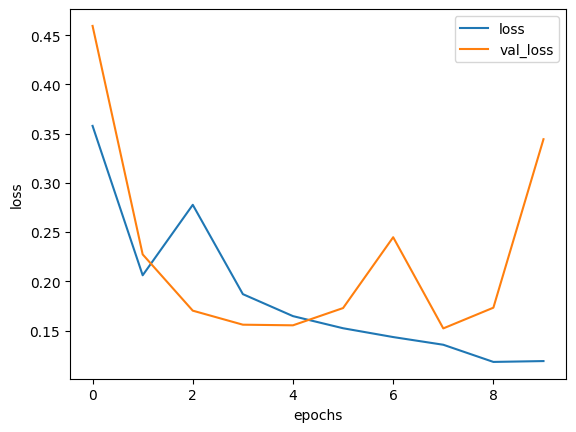

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss' ,'val_loss'])

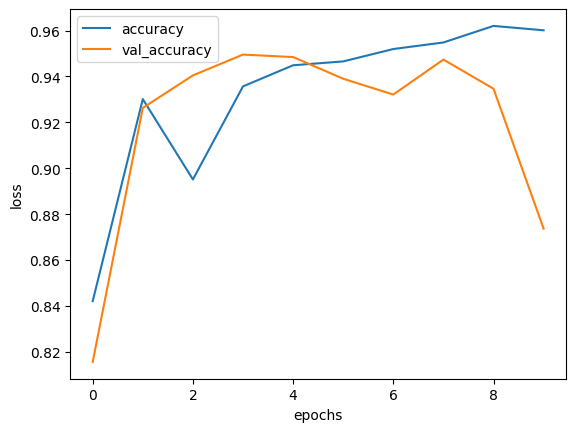

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['accuracy' ,'val_accuracy'])

In [16]:
test_dataset = test_dataset.batch(1)

In [17]:
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 244, 244, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [18]:
model.evaluate(test_dataset)

2757/2757 [==============================] - 21s 3ms/step - loss: 0.3364 - accuracy: 0.8741


[0.3363534212112427, 0.8741385340690613]

In [19]:
model.predict(test_dataset.take(1))[0][0]

1/1 [==============================] - 12s 12s/step


0.10418997

In [20]:
def check(x):
    if x < 0.5:
        return 'P'
    else:
        return 'U'


In [21]:
check(model.predict(test_dataset.take(1)))

1/1 [==============================] - 13s 13s/step


'U'

1/1 [==============================] - 0s 20ms/step


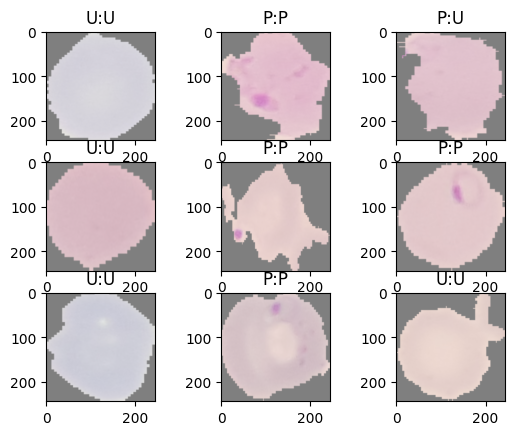

In [22]:


for i, (image, label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((image[0] + 1) / 2)  # Rescale pixel values if necessary
    plt.title(f"{check(label.numpy()[0])}:{check(model.predict(image)[0][0])}")


plt.show()

